# Investigating the Effect of Changing Number of Photons

This notebook investigate how the variation of number of photons will affect the TCSPC and phasor result.

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve
from scipy import stats
from sympy import symbols, solve, Eq, Function, nsolve
from sympy.matrices import Matrix
import sympy as sp
from scipy.optimize import curve_fit
from lmfit import Model, Parameters
import lmfit
import inspect
import pandas as pd
import numdifftools

plt.style.use('seaborn-v0_8-deep')

In [2]:
# Create an array for different run times, varying the number of photons
run_time_array = np.arange(20*60,8*60*60,50)    # 20 minutes to 8 hours

#Set default params
irfwidth = 0.001

rng = np.random.default_rng()

#### Questions
- value of irfwidth
- MC？

## TCSPC
Perform analysis on EGFP with two close lifetimes of:
| $\tau_1$      | $3.07 ns$  |
|---------------|----------|
| $\tau_2$      | $2.43 ns$  |.

### Generate TCSPC Data

In [3]:
def TCSPCsim(amplitudes, lifetimes, run_time, n_bins=380, window=20, bg=10, t0=10/19, deconv=False):
    '''Generate TCSPC fluorescence decay data (not Monte Carlo method).'''
    '''
    Inputs:
    - amplitudes: fractional intensities of each lifetime component (1d array)
    - lifetimes: lifetime array (1d array)
    - run_time: run time in seconds
    - irfwidth: sigma of Gaussian IRF
    - n_bins: number of histogram bins, default is 380
    - window: decay data time window in ns, default is 20
    - bg: background count rate, default is 10 counts per second
    - t0: IRF offset in ns, default is 10/19
    - deconv: if True, deconvolve the data with the IRF, default is False

    Outputs: 
    - t (time array)
    - noisydecay (decay data)
    '''
    t = np.linspace(0, window, n_bins)

    global irfwidth
        
    # Check that each amplitude has a corresponding lifetime
    if len(amplitudes) != len(lifetimes):
        return None, None
    
    # Generate the pure decay signal
    pure_decay = sum([amplitudes[j] * np.exp(-t / lifetimes[j]) for j in range(len(lifetimes))])
    
    # Generate the IRF
    irf_kernel = stats.norm.pdf(t, loc=t0, scale=irfwidth)
    
    # Convolve the pure decay with the IRF
    Iconvol = convolve(pure_decay, irf_kernel, mode='full')[:n_bins] / np.sum(irf_kernel)
    
    # Calculate the number of fluorescence counts
    fluorate = 2500 - bg  # Subtract background to get fluorescence rate
    totalfluorescence = fluorate * run_time
    noiseless = totalfluorescence * Iconvol / np.sum(Iconvol)
    noiseless += bg * run_time / n_bins  # Add background counts evenly
    
    # Add Poisson noise
    noisydecay = rng.poisson(noiseless)
    
    # Optionally deconvolve
    #if deconv:
        # Assuming deconv_fft function is defined elsewhere to handle deconvolution
    #    noisydecay = deconv_fft(noisydecay, kernel(t, t0, irfwidth))
    
    return t, noisydecay

def plot_TCSPC_decay(t, y, tau, logy=True, deconv=False, bins=None):
    '''Plot TCSPC decay.'''
    '''
    Inputs:
    - t: time array corresponding to the y data.
    - y: photon number array (ydata).
    - tau: lifetimes used in the simulation or data analysis.
    - logy: if True, y-axis will be on a logarithmic scale; linear otherwise.
    - deconv: if True, apply deconvolution to y using the instrument response function (IRF).
    - bins: the bins used for the histogram or decay curve; necessary if deconvolution is applied.
    '''
    fig, ax = plt.subplots() 

    ax.set_title(r'TCSPC Fluorescence Decay ($\tau =$' + ', '.join([f'{lifetime} ns' for lifetime in tau]) + ')')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Photon Count')
    
    if logy:
        ax.set_yscale('log')
    
    #if deconv and bins is not None:
        # Assuming deconv_fft and kernel functions are defined elsewhere.
        # You might need to adjust the parameters of kernel function based on your actual use case.
    #    y = deconv_fft(y, kernel(bins))
    
    # Check if y is a single dataset or contains multiple datasets
    if y.ndim == 1:
        # Single dataset
        ax.plot(t, y, label='Data')
    else:
        # Multiple datasets, e.g., from simulations with different lifetimes
        for i, y_i in enumerate(y):
            ax.plot(t, y_i, label=f'{tau[i]} ns')
    
    ax.legend()

    return

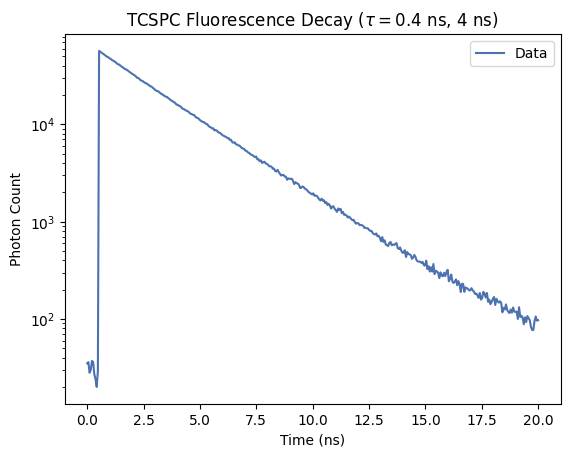

In [4]:
# Generate TCSPC data
EGFPt,EGFPy = TCSPCsim([0.503,0.497],[3.07,2.43], 20*60)
plot_TCSPC_decay(EGFPt, EGFPy, [0.4,4])

### Fit with COMBYLA

In [5]:
def exp2(t,A1,tau1,tau2):
    '''returns bi-exponential A1*exp(-t/tau1) + (1-A1)*exp(-t/tau2)
       t    time array (ns)
       A1   amplitude 1
       tau1 lifetime 1 (ns)
       tau2 lifetime 2 (ns)
    '''
    return A1*np.exp(-t/tau1)+(1-A1)*np.exp(-t/tau2)

def exp_fit(func,tdata,ydata,guess,run_time,end = int((15/20*380)),bg = 10,weights = None,method = 'cobyla'):
    '''use least-square fit for given exponential function (exp1 or exp2)
       Inputs:
       func      exp function to be fitted 
       tdata     time array (non-trimmed)
       ydata     photon count (non-trimmed)
       guess     guess intial parameters for fitting
       end       trim the end point to avoid low count statistics
       bg        background count per s
       run_time  run_time (s)
       weights   weights for the data points of the fit (1/yerr)
       method    fit method
       Outputs:
       result        lmfit result
       params_opt    fitted parameters
       chi2_red      reduced chi2
       fit_report    fit_report from lmfit
       '''
    model = Model(func)
    params = Parameters()
    # Get the parameter names and default values from the input function
    params_name = inspect.signature(func).parameters
    params_name = list(params_name.keys())[1:]  # Exclude 'x' from parameters
    for i,name in enumerate(params_name):
    # Add initial guess value for the parameter
        params.add(name,value=guess[i],min = 0)

    #Trim and scale data for fitting
    ydata = ydata-np.full(len(ydata),int(bg*run_time/len(tdata)))#subtract background from each bin
    max_idx = np.argmax(ydata) #index of data point with maximum photon count N(0)
    tdata = tdata[:end-max_idx] #start from t = 0
    ydata = ydata[max_idx:end]  #start from max.
    ydata = ydata/ydata[0] # scale y data such that the beginning is 1 

    
    result = model.fit(ydata, params, t=tdata,weights = weights,method = method) #perform least squares fit
    params_opt = result.params #optimized params
    chi2= result.chisqr #chi squared
    chi2_red = result.chisqr/(len(tdata)-len(params))
    fit_report = result.fit_report()
    return result, params_opt, chi2_red, fit_report


In [11]:
result,params,chi2,report=exp_fit(exp2,t, y,[0.503,3.07,2.43],20*60,method = 'cobyla')
print(report)

[[Model]]
    Model(exp2)
[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 290
    # data points      = 275
    # variables        = 3
    chi-square         = 6.5545e-05
    reduced chi-square = 2.4097e-07
    Akaike info crit   = -4187.62566
    Bayesian info crit = -4176.77535
    R-squared          = 0.99999600
##  Warning: uncertainties could not be estimated:
[[Variables]]
    A1:    0.50063349 (init = 0.503)
    tau1:  3.13636327 (init = 3.07)
    tau2:  2.37524501 (init = 2.43)


In [20]:
result,params,chi2,report=exp_fit(exp2,t, y,[0.503,3.07,2.43],20*60,method = 'leastsq')
result

params['tau1'].stderr

0.043382919954862265

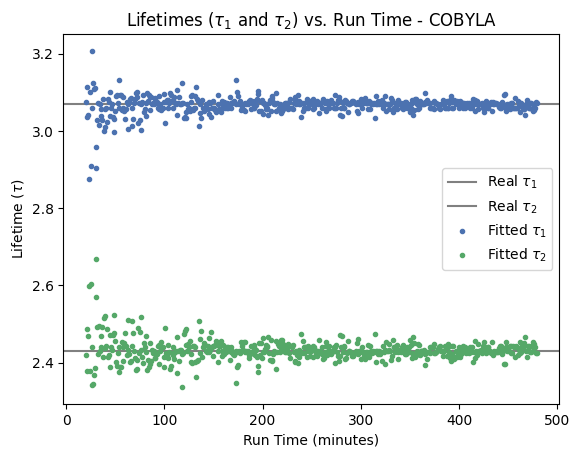

In [22]:
# Analyse for increasing run time
tau1_array=[]
tau2_array=[]

for i in run_time_array:
    t=[]
    y=[]

    t,y = TCSPCsim([0.503,0.497],[3.07,2.43], i)
    result,params,chi2,report=exp_fit(exp2,t, y,[0.503,3.07,2.43],i,method = 'cobyla')

    tau1_array.append(params['tau1'].value)
    tau2_array.append(params['tau2'].value)

# Plot the fitted lifetimes against run time
plt.figure()

# Plot fitted values
plt.errorbar(run_time_array/60, tau1_array, fmt='.', linestyle='none', label='Fitted $\\tau_1$')
plt.errorbar(run_time_array/60, tau2_array, fmt='.', linestyle='none', label='Fitted $\\tau_2$')

# Plot real values
plt.axhline(y=3.07, color='grey', linestyle='-', label='Real $\\tau_1$')
plt.axhline(y=2.43, color='grey', linestyle='-', label='Real $\\tau_2$')

plt.xlabel('Run Time (minutes)')  # X-axis label
plt.ylabel('Lifetime ($\\tau$)')  # Y-axis label
plt.title('Lifetimes ($\\tau_1$ and $\\tau_2$) vs. Run Time - COBYLA')  # Chart title
plt.legend()

plt.show()

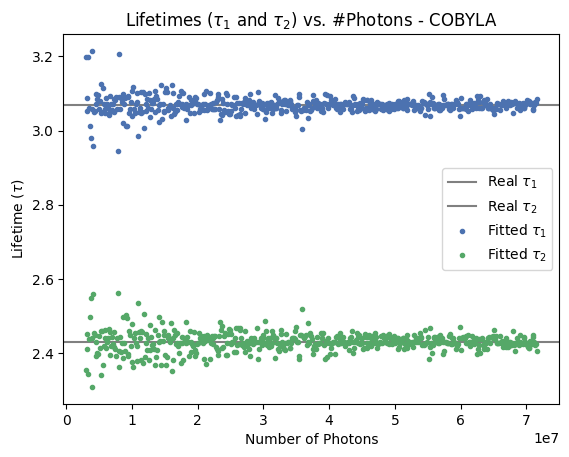

In [7]:
# A quick plot against #photon = time*2490
plt.figure()

# Plot fitted values
plt.errorbar(run_time_array*2490, tau1_array, fmt='.', linestyle='none', label='Fitted $\\tau_1$')
plt.errorbar(run_time_array*2490, tau2_array, fmt='.', linestyle='none', label='Fitted $\\tau_2$')

# Plot real values
plt.axhline(y=3.07, color='grey', linestyle='-', label='Real $\\tau_1$')
plt.axhline(y=2.43, color='grey', linestyle='-', label='Real $\\tau_2$')

plt.xlabel('Number of Photons')  # X-axis label
plt.ylabel('Lifetime ($\\tau$)')  # Y-axis label
plt.title('Lifetimes ($\\tau_1$ and $\\tau_2$) vs. #Photons - COBYLA')  # Chart title
plt.legend()

plt.show()

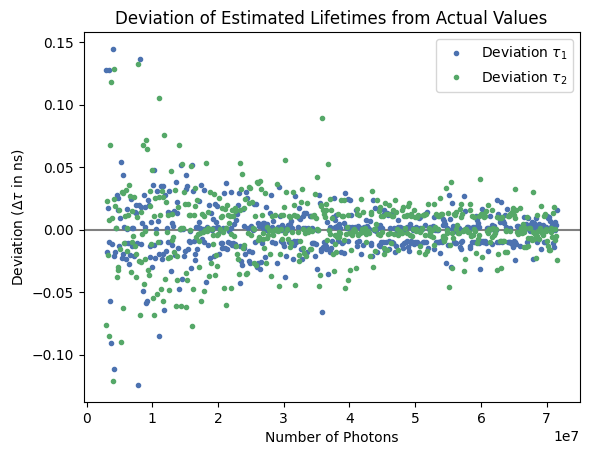

In [8]:
# Calculate deviations from actual values
deviation_tau1 = [tau - 3.07 for tau in tau1_array]
deviation_tau2 = [tau - 2.43 for tau in tau2_array]

# Plotting deviations for tau1 and tau2 against run time
plt.figure()

#Plot deviations
plt.errorbar(run_time_array*2490, deviation_tau1, fmt='.', linestyle='none', label='Deviation $\\tau_1$')
plt.errorbar(run_time_array*2490, deviation_tau2, fmt='.', linestyle='none', label='Deviation $\\tau_2$')

plt.axhline(y=0, color='grey', linestyle='-')

plt.xlabel('Number of Photons')
plt.ylabel('Deviation ($\\Delta \\tau$ in ns)')
plt.title('Deviation of Estimated Lifetimes from Actual Values')
plt.legend()

plt.show()

### Fit with Least Squares

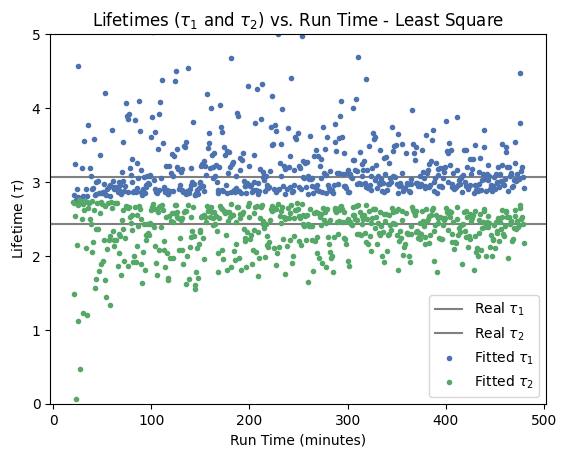

In [40]:
# Analyse for increasing run time
tau1_array_lsq=[]
tau2_array_lsq=[]
dtau1_array_lsq=[]
dtau2_array_lsq=[]

for i in run_time_array:
    t=[]
    y=[]

    t,y = TCSPCsim([0.503,0.497],[3.07,2.43], i)
    result_lsq,params_lsq,chi2_lsq,report_lsq = exp_fit(exp2,t, y,[0.503,3.07,2.43],i,method = 'leastsq')

    tau1_array_lsq.append(params_lsq['tau1'].value)
    tau2_array_lsq.append(params_lsq['tau2'].value)
    dtau1_array_lsq.append(params_lsq['tau1'].stderr)
    dtau2_array_lsq.append(params_lsq['tau2'].stderr)

# Plot the fitted lifetimes against run time
plt.figure()
plt.ylim(0, 5) # Lifetimes often goes quite wrong for the least square method, limit y axis for better plot

# Plot fitted values
plt.errorbar(run_time_array/60, tau1_array_lsq, fmt='.', linestyle='none', label='Fitted $\\tau_1$')
plt.errorbar(run_time_array/60, tau2_array_lsq, fmt='.', linestyle='none', label='Fitted $\\tau_2$')

# Plot real values
plt.axhline(y=3.07, color='grey', linestyle='-', label='Real $\\tau_1$')
plt.axhline(y=2.43, color='grey', linestyle='-', label='Real $\\tau_2$')

plt.xlabel('Run Time (minutes)')  # X-axis label
plt.ylabel('Lifetime ($\\tau$)')  # Y-axis label
plt.title('Lifetimes ($\\tau_1$ and $\\tau_2$) vs. Run Time - Least Square')  # Chart title
plt.legend()

plt.show()

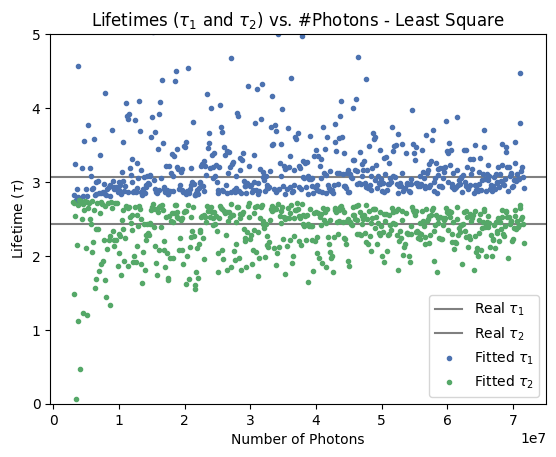

In [42]:
# A quick plot against #photon = time*2490
plt.figure()
plt.ylim(0, 5) # Lifetimes often goes quite wrong for the least square method, limit y axis for better plot

# Plot fitted values
plt.errorbar(run_time_array*2490, tau1_array_lsq, fmt='.', linestyle='none', label='Fitted $\\tau_1$')
plt.errorbar(run_time_array*2490, tau2_array_lsq, fmt='.', linestyle='none', label='Fitted $\\tau_2$')

# Plot real values
plt.axhline(y=3.07, color='grey', linestyle='-', label='Real $\\tau_1$')
plt.axhline(y=2.43, color='grey', linestyle='-', label='Real $\\tau_2$')

plt.xlabel('Number of Photons')  # X-axis label
plt.ylabel('Lifetime ($\\tau$)')  # Y-axis label
plt.title('Lifetimes ($\\tau_1$ and $\\tau_2$) vs. #Photons - Least Square')  # Chart title
plt.legend()

plt.show()

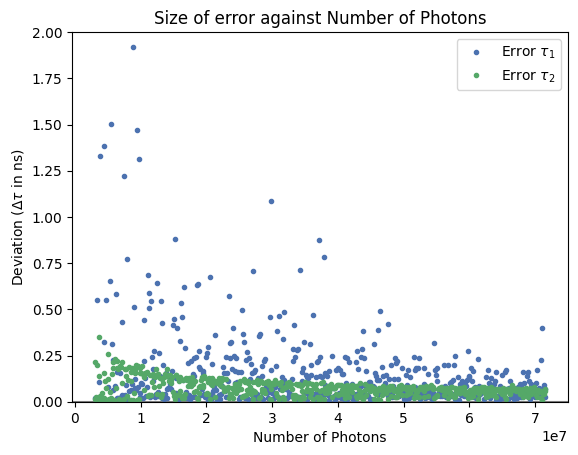

In [48]:
# Compare error against number of photons
plt.figure()
plt.ylim(0, 2) # Lifetimes often goes quite wrong for the least square method, limit y axis for better plot

#Plot deviations
plt.errorbar(run_time_array*2490, dtau1_array_lsq, fmt='.', linestyle='none', label='Error $\\tau_1$')
plt.errorbar(run_time_array*2490, dtau2_array_lsq, fmt='.', linestyle='none', label='Error $\\tau_2$')

plt.axhline(y=0, color='grey', linestyle='-')

plt.xlabel('Number of Photons')
plt.ylabel('Deviation ($\\Delta \\tau$ in ns)')
plt.title('Size of error against Number of Photons')
plt.legend()

plt.show()

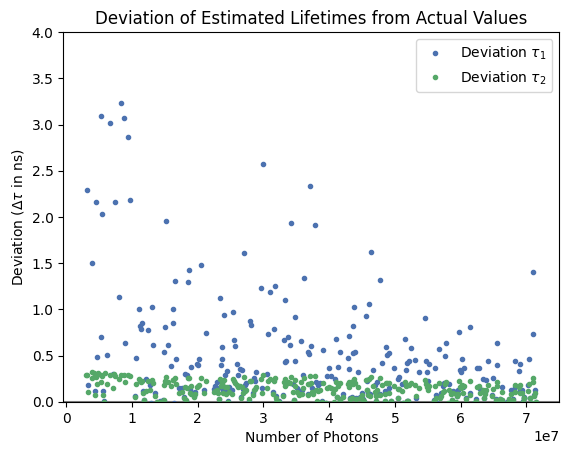

In [51]:
# Calculate deviations from actual values
deviation_tau1_lsq = [tau - 3.07 for tau in tau1_array_lsq]
deviation_tau2_lsq = [tau - 2.43 for tau in tau2_array_lsq]

# Plotting deviations for tau1 and tau2 against run time
plt.figure()
plt.ylim(0, 4) # Lifetimes often goes quite wrong for the least square method, limit y axis for better plot

#Plot deviations
plt.errorbar(run_time_array*2490, deviation_tau1_lsq, fmt='.', linestyle='none', label='Deviation $\\tau_1$')
plt.errorbar(run_time_array*2490, deviation_tau2_lsq, fmt='.', linestyle='none', label='Deviation $\\tau_2$')

plt.axhline(y=0, color='grey', linestyle='-')

plt.xlabel('Number of Photons')
plt.ylabel('Deviation ($\\Delta \\tau$ in ns)')
plt.title('Deviation of Estimated Lifetimes from Actual Values')
plt.legend()

plt.show()